In [1]:
import sys


sys.path.append("../src/")

In [2]:
from sennet.core.mmap_arrays import read_mmap_array
import matplotlib.pyplot as plt
import numpy as np


%matplotlib widget

In [42]:
mmap1 = read_mmap_array("/home/clay/research/kaggle/sennet/data_dumps/processed/kidney_1_dense/image/")
mmap2 = read_mmap_array("/home/clay/research/kaggle/sennet/data_dumps/processed/kidney_2/image/")
mmap3 = read_mmap_array("/home/clay/research/kaggle/sennet/data_dumps/processed/kidney_3_sparse/image/")
label_mmap3 = read_mmap_array("/home/clay/research/kaggle/sennet/data_dumps/processed/kidney_3_sparse/label/")

In [4]:
def plot_percentile(mmap, p):
    percentiles = np.percentile(mmap.data.reshape((mmap.shape[0], -1)), [p, 100-p], axis=1)
    n_channels = mmap.data.shape[0]
    channel_margin = 0.2
    channel_lb = int(channel_margin * n_channels)
    channel_ub = int((1-channel_margin) * n_channels)
    lb, ub = global_percentile = np.percentile(mmap.data[channel_lb: channel_ub, :], [p, 100-p])
    plt.plot(percentiles[0, :], label="lb")
    plt.plot(percentiles[1, :], label="ub")
    plt.axhline(lb)
    plt.axhline(ub)
    plt.legend()

In [ ]:
plot_percentile(mmap1, 1)

In [ ]:
plot_percentile(mmap2, 1)

In [ ]:
plot_percentile(mmap3, 1)

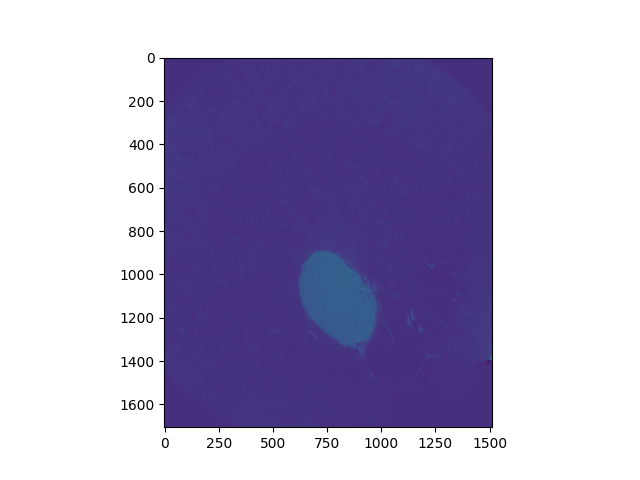

In [8]:
plt.figure()

z, y, x = 45, 993, 751
slice = mmap3.data[z, ...]

plt.imshow(slice)

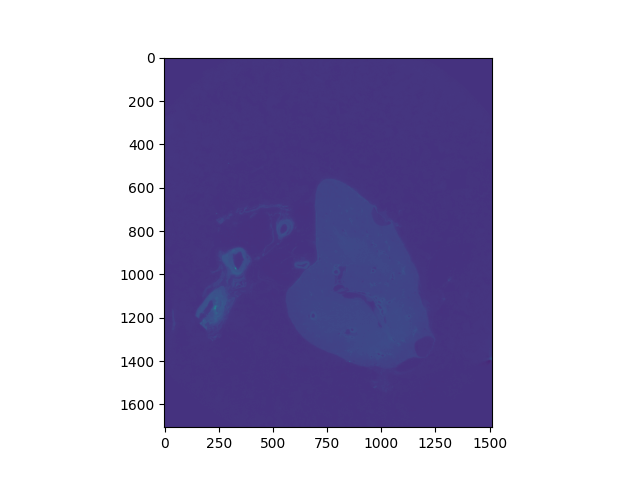

In [9]:
plt.figure()
plt.imshow(mmap3.data[201, ...])

In [50]:
from pathlib import Path
from tqdm import tqdm
import cv2


mmap_pred = read_mmap_array("/home/clay/research/kaggle/sennet/data_dumps/predicted/for_rg/kidney_3_sparse/chunk_00/mean_prob/")
pred_out_path = Path("/home/clay/research/kaggle/sennet/data_dumps/pred_dump")
pred_out_path.mkdir(exist_ok=True, parents=True)
threshold = 0.03

for i in tqdm(range(mmap_pred.shape[0])):
    file_name = f"{str(i).zfill(4)}.png"
    _img = np.clip(np.ascontiguousarray(mmap_pred.data[i, ...] / 2 / threshold * 255), 0, 255).astype(np.uint8)
    cv2.imwrite(str(pred_out_path / file_name), _img)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1035/1035 [00:33<00:00, 31.13it/s]


In [55]:
mmap4 = read_mmap_array("/home/clay/research/kaggle/sennet/data_dumps/predicted/for_rg/kidney_3_sparse/chunk_00/out", mode="readwrite")

In [56]:
print(mmap4.data.max())
print(mmap4.data.min())
mmap_sum = mmap4.data.sum()
print(mmap_sum)
print(mmap_sum / np.product(mmap4.data.shape))

True
False
82796940
0.03105402959490884


In [49]:
from pathlib import Path
from tqdm import tqdm
import cv2


out_path = Path("/home/clay/research/kaggle/sennet/data_dumps/watershed_dump")
out_path.mkdir(exist_ok=True, parents=True)

for i in tqdm(range(mmap4.shape[0])):
    file_name = f"{str(i).zfill(4)}.png"
    _img = np.ascontiguousarray(mmap4.data[i, ...].astype(np.uint8) * 255)
    cv2.imwrite(str(out_path / file_name), _img)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1035/1035 [00:06<00:00, 168.67it/s]


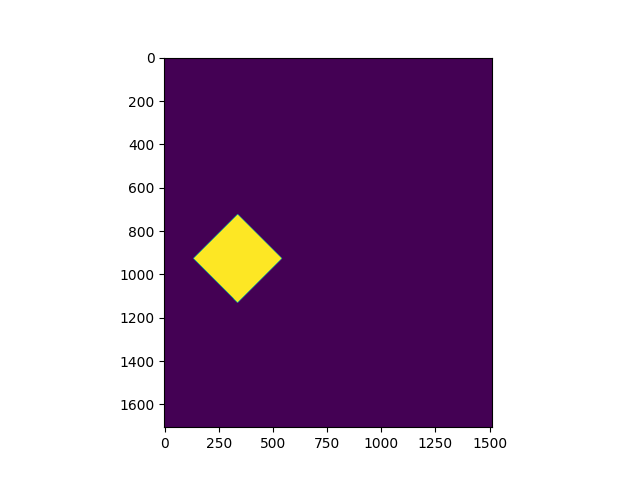

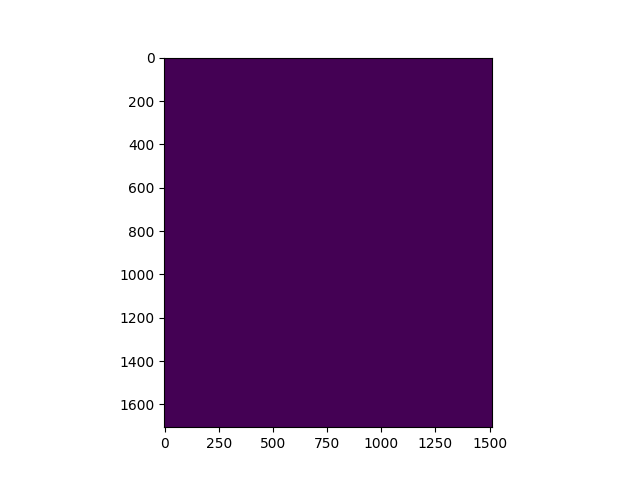

In [57]:
i = 0
plt.figure()
plt.imshow(mmap4.data[i, ...])
plt.figure()
plt.imshow(label_mmap3.data[i, ...])

In [58]:
mmap4.data[:] = False
mmap4.data.flush()

In [44]:
copied_pred = np.ascontiguousarray(mmap4.data.copy())
copied_label = np.ascontiguousarray(label_mmap3.data.copy())

In [45]:
tp = (copied_pred & copied_label).sum()
fp = (copied_pred & ~copied_label).sum()
fn = (~copied_pred & copied_label).sum()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

In [46]:
print(precision)
print(recall)
print(f1)

0.3132085540776416
0.9979604830866543
0.47678026413771873
